# Data Exploration

This notebook is used to clean and explore the data.

In [36]:
import sys
print(sys.executable)

/Users/ionutdiaconu/ml/my_env/bin/python3


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## Load Data

In [38]:
data = pd.read_csv('visitors-and-views-of-the-city-of-brussels-website-per-page-from-2023.csv', delimiter=';')
data.head(5)

,Year,Page,Views,Active users
0,2023,Plaisirs d'Hiver et marché de Noël 2023 | Vill...,195511,138293
1,2023,Heures d'ouverture | Ville de Bruxelles,85934,63396
2,2023,Population & Etat civil - heures d'ouverture |...,66649,44437
3,2023,Contact | Ville de Bruxelles,59018,40850
4,2023,Grand-Place of Brussels | City of Brussels,56364,46408


In [39]:
# Check for missing, duplicate values and data types
data.isnull().sum()
data.shape
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26744 entries, 0 to 26743
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Year          26744 non-null  int64 
 1   Page          26744 non-null  object
 2   Views         26744 non-null  int64 
 3   Active users  26744 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 835.9+ KB


In [40]:
# change column names to lowercases
data.columns = data.columns.str.lower()

In [41]:
# Year column is not in datetime format
data['year'] = pd.to_datetime(data['year'], format='%Y')

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26744 entries, 0 to 26743
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   year          26744 non-null  datetime64[ns]
 1   page          26744 non-null  object        
 2   views         26744 non-null  int64         
 3   active users  26744 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 835.9+ KB


In [43]:
# Remove pages with weird characters or missing names
data = data[~data['page'].str.contains(r'\?{3,}|This page no longer exists', na=False, regex=True)]

In [44]:
# let's plot top 10 most visited pages
top_10 = data.groupby('page')['views'].sum().sort_values(ascending=False).head(10)

/var/folders/b1/rks16rxd6gn2ccn7t94n7r040000gn/T/ipykernel_1479/3300013225.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10.values, y=top_10.index, palette='viridis')


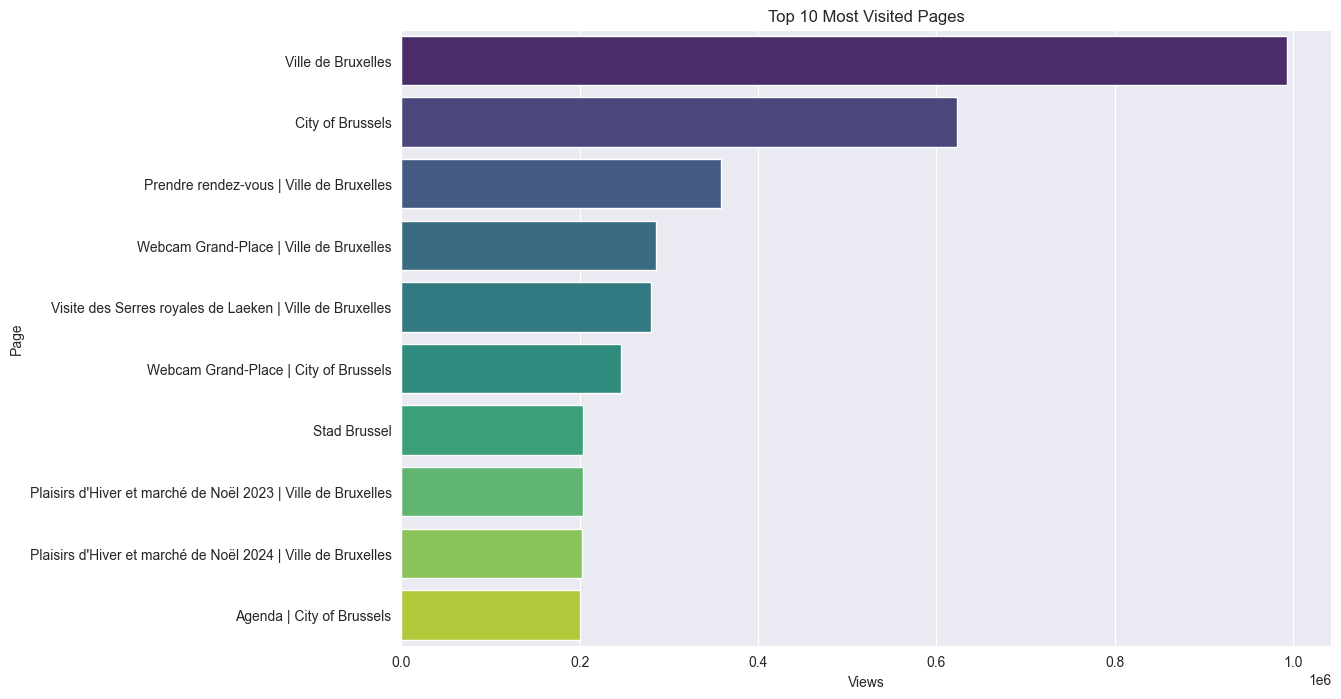

In [45]:
# Plotting the bar chart
plt.figure(figsize=(12, 8))
sns.barplot(x=top_10.values, y=top_10.index, palette='viridis')
plt.xlabel('Views')
plt.ylabel('Page')
plt.title('Top 10 Most Visited Pages')
plt.show()

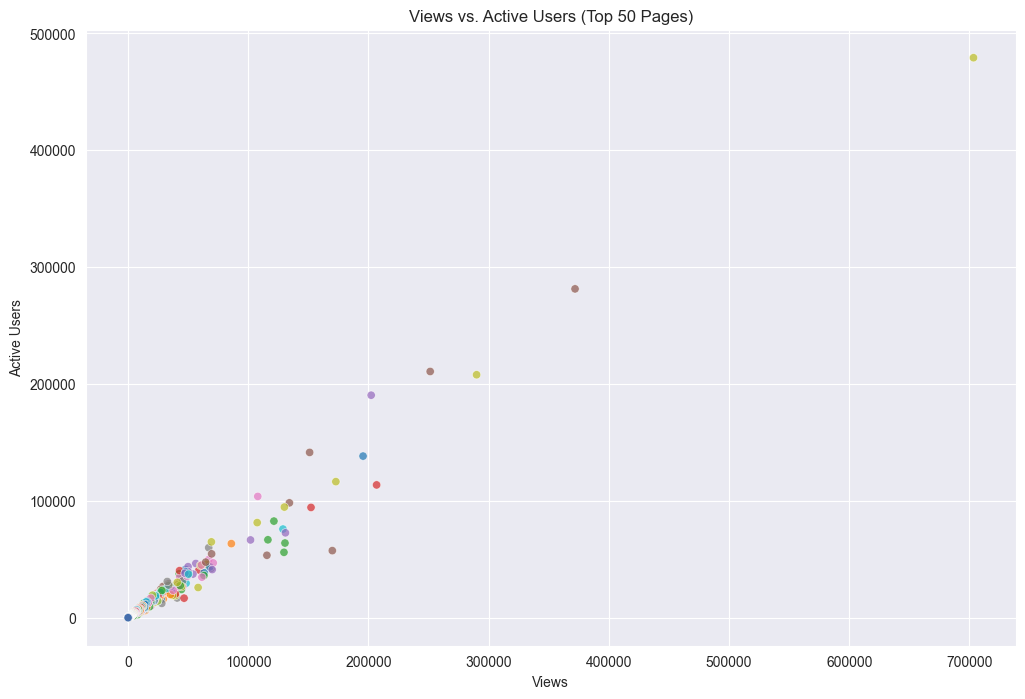

In [46]:
# # Get top 50 most viewed pages
# top_pages = data.groupby('page')['views'].sum().nlargest(250).index
# 
# # Filter dataset to only include top pages
# filtered_data = data[data['page'].isin(top_pages)]

# Scatter plot with limited pages
plt.figure(figsize=(12, 8))
sns.scatterplot(x='views', y='active users', data=data, hue='page', palette='tab10', alpha=0.7)
plt.xlabel('Views')
plt.ylabel('Active Users')
plt.title('Views vs. Active Users (Top 50 Pages)')
plt.legend([],[], frameon=False)  # Hides legend for better clarity
plt.show()

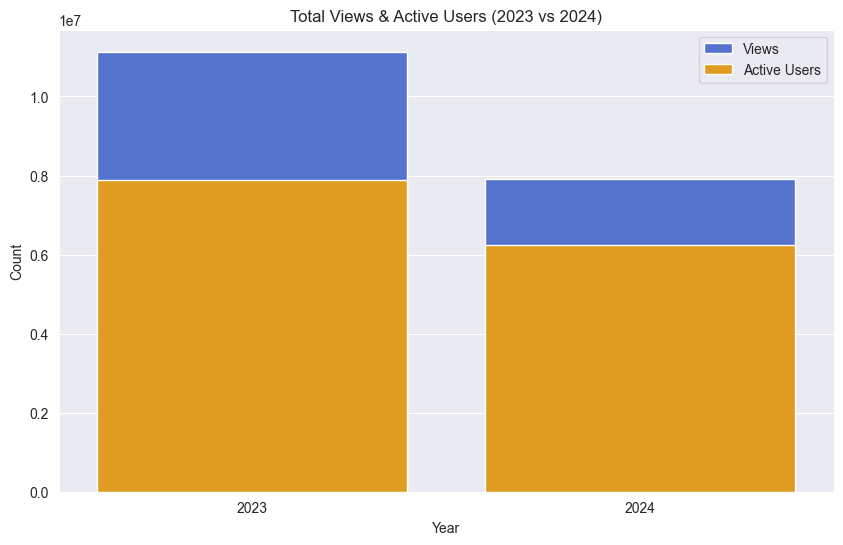

In [47]:
# year over year trends
# Aggregate by year
yearly_stats = data.groupby('year')[['views', 'active users']].sum().reset_index()

# Bar chart for total views & active users by year
plt.figure(figsize=(10, 6))
sns.barplot(x=yearly_stats['year'].dt.year, y=yearly_stats['views'], color='royalblue', label='Views')
sns.barplot(x=yearly_stats['year'].dt.year, y=yearly_stats['active users'], color='orange', label='Active Users')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Total Views & Active Users (2023 vs 2024)')
plt.legend()
plt.show()


⚠️ No pages with low engagement found! Adjusting threshold...


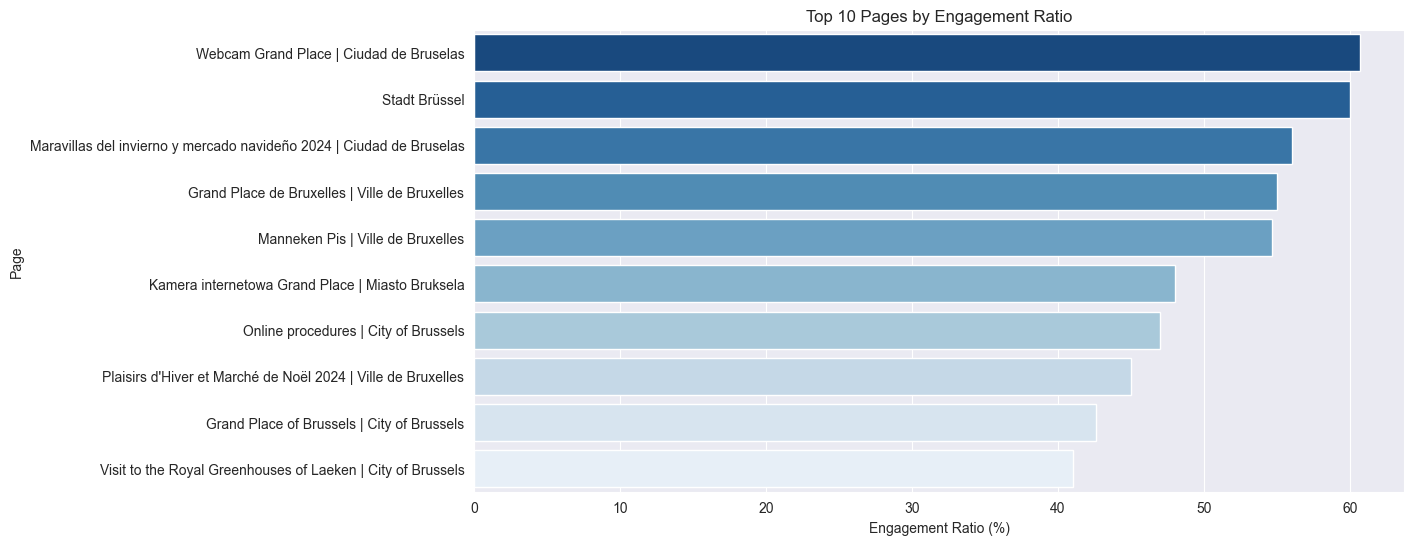

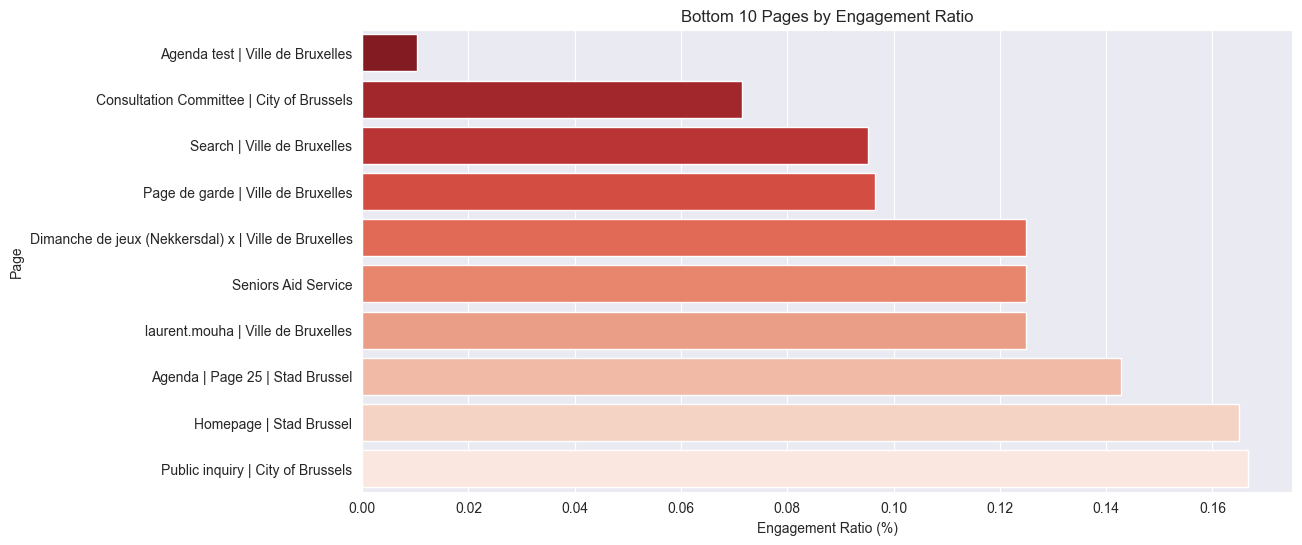

In [65]:
# Ensure Engagement Ratio is calculated properly
data['engagement_ratio'] = (data['active users'] / data['views'])

# Remove NaNs and infinite values
data = data.replace([np.inf, -np.inf], np.nan).dropna(subset=['engagement_ratio'])

# Group by page and get mean engagement ratio
engagement_ratios = data.groupby('page')['engagement_ratio'].mean()

# Get top 10 pages with highest engagement
top_engagement = engagement_ratios.nlargest(10)

# Get bottom 10, but ensure they are > 0
low_engagement = engagement_ratios.nsmallest(20)  # Get 20 in case of zeros
low_engagement = low_engagement[low_engagement > 0].head(10)  # Filter out zeros

# If still empty, adjust threshold
if low_engagement.empty:
    print("⚠️ No pages with low engagement found! Adjusting threshold...")
    low_engagement = engagement_ratios[engagement_ratios > 0].nsmallest(10)

# ✅ Plot Top 10 Engaged Pages
plt.figure(figsize=(12, 6))
sns.barplot(x=top_engagement.values, y=top_engagement.index, hue=top_engagement.index, palette='Blues_r', legend=False)
plt.xlabel('Engagement Ratio (%)')
plt.ylabel('Page')
plt.title('Top 10 Pages by Engagement Ratio')
plt.show()

# ✅ Plot Bottom 10 Engaged Pages
plt.figure(figsize=(12, 6))
sns.barplot(x=low_engagement.values, y=low_engagement.index, hue=low_engagement.index, palette='Reds_r', legend=False)
plt.xlabel('Engagement Ratio (%)')
plt.ylabel('Page')
plt.title('Bottom 10 Pages by Engagement Ratio')
plt.show()


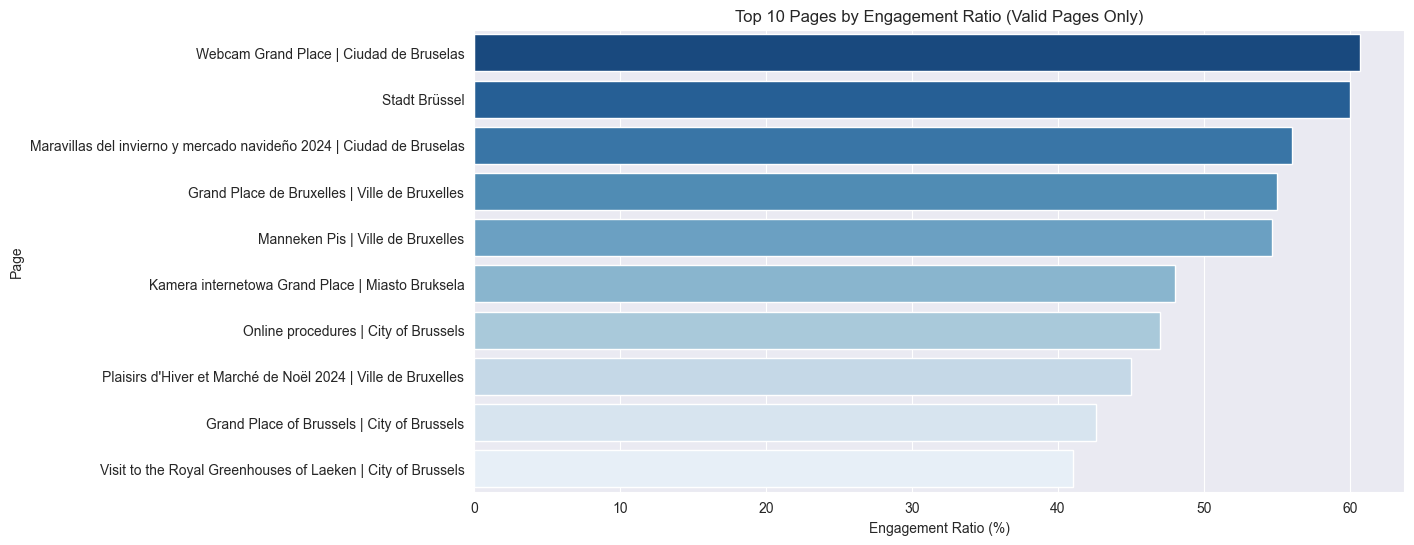

In [63]:
# Apparently the first page which has the highest engagement ratio, does not exist
# We will remove all pages with names indicating that they do not exist
# Remove pages with names indicating they don't exist
invalid_pages = [
    "This page does not exist or no longer exists | City of Brussels",
    "????????? ??) | ????? ????????",  # If you see corrupted text
]
invalid_pages.append("Cette page n'existe pas (plus) | Ville de Bruxelles")  # French version

# Filter dataset
data = data[~data['page'].isin(invalid_pages)]

# Recalculate engagement ratio
engagement_ratios = data.groupby('page')['engagement_ratio'].mean()

# Get new top 10 without invalid pages
top_engagement = engagement_ratios.nlargest(10)

# Plot again
plt.figure(figsize=(12, 6))
sns.barplot(x=top_engagement.values, y=top_engagement.index, hue=top_engagement.index, palette='Blues_r', legend=False)
plt.xlabel('Engagement Ratio (%)')
plt.ylabel('Page')
plt.title('Top 10 Pages by Engagement Ratio (Valid Pages Only)')
plt.show()


In [64]:
# let's export our cleaned and prepared dataset
data.to_csv('cleaned_data.csv', index=False)